Suhas Thejaswi and Clemens Westrup

# Introduction

This report is the result of a term project for the course “Algorithmic Methods of Data Mining” at Aalto University. The goal of this project was analyze randomized algorithms for streams. In particular, the task was compute the so-called zero'th and second frequency moments of a stream, first using algorithms for exact computation and afterwards comparing these to randomized algorithms for approximate computation, which offer substantial gains in terms of space complexity in trade for result precision.

"The frequency moments of a sequence containing $m_i$ elements of type $i$, for $1 ≤ i ≤ n$, are the numbers $F_k =  \sum_{i=1}^n m_i^k$" as defined by Alon, Matias and Szegedy [3]. In this project the frequency moments of interest were $F_0$ $-$ the number of distinct elements in the stream $-$ and $F_2$ which describes the "_repeat rate_ or _Gini’s index of homogeneity_ needed in order to compute the _surprise index_ of the sequence" [3],[6]. The data given to compute these frequency moments in this project was a file of approximately 8.8 GB with 911.740.903 unprocessed words from twitter in UTF format to be used in a stream fashion.

The report is structured as follows: First the exact computation of the frequency moments is discussed, afterwards the approaches to approximate computation and their results will be presented. As the topic of choosing a family of hash functions plays an important role in these randomized algorithms we will discuss this in seperate section. Afterwards we will conclude the report by summarizing our results and giving a recommendation for the setup for computing the frequency moments $F_0$ and $F_2$ in a similar setting. 

The code to run experiments for this project was implemented in `C`, `Julia` and `Python`. This report uses Julia [1] in combination with the Jupyter notebook [2]. With these prerequisites in place the project report can also be cloned form the following GitHub repository and run interactively: https://github.com/cle-ment/frequency-moments. In addition the following Julia packages are needed:

In [5]:
using Gadfly, DataFrames, SHA, Murmur3, Images, ImageMagick

# Exact Computation of Frequency Moments

The exact computation of the zero'th and second frequency moments is first discussed with the contraint of using only a single pass on the data, i.e. scanning the stream element by element and only seeing every element once. Afterwards we look at the exact computation when loosening this constraint and using multiple passes on the data, and the possible advantages of doing so. Lastly we will show the results of the exact computation on the whole data.

## Single Pass

Computation using a single pass was using two different approaches. The first way was to sort the file in-place and calculate the unique elements and self-join of the stream from it. The second approach to generate a dictionary of all words occuring in the stream, practically holding a counter for each word. This way the size of the dictionary is the $F_0$ moment of the stream and the summing over the squared counters for the word gives the $F_2$ moment.

### Computation using in-place sort

This aproach can be achieved using simple unix tools. In Julia we have access to the shell so these commands can be implemented as Julia functions. 

Computing $F_0$ can be achieved using the following unix command: 

    $> sort <file> | uniq -c | wc -l

The computation of $F_2$ can be done using the following command: 

    $> sort <file> | uniq -c | tr -s ' ' | cut -d ' ' -f 2  | awk '{x+=$0*$0}END{print x}'

The complexity in terms of time is $\mathcal{O}(n*log(n) + n)$ in expectation to sort the stream and count the frequencies and the space complexity is $\mathcal{O}(n)$ to store the sorted stream temporarily.

### Computation using a dictionary

For both algorithms we will use a function that reads the stream/file once, stores the counts of each item in a Dictionary and returns an array with the counts of the items. Hence the space and time complexity are in $\mathcal{O}(n)$ since we need to keep an entry for each element in the stream in our Dictionary (space $\mathcal{O}(m)$) and we pass through each element once (time $\mathcal{O}(n)$).

In [79]:
function count_words(stream::IOStream, inputSize=0)
    wordcounts = Dict{UTF8String,Int}();
    # preallocate memory
    if inputSize > 0 
        sizehint!(wordcounts, inputSize)
    end
    while !eof(stream)
        word = readline(stream)
        wordcounts[word] = get(wordcounts, word, 0) + 1
    end
    return collect(values(wordcounts))
end;

Compuing $F_0$ from our count array is then simply the length of the array since it contains an entry for every item seen in the stream.

In [80]:
onePassF0(file) = length(open(count_words, file));

To compute $F_2$ we will first need a function which squares an element. In Julia we can then simply vectorize this function using a macro so it takes an Array and can compute the values in abritary order, similarly to vector / matrix multiplication in Numpy, Matlab etc. This speeds up computation especially on multi-core machines.

In [81]:
square(x) = x^2
@vectorize_1arg Number square;

Now we can pass the count array from above into the vectorized square function and sum the result to compute $F_2$.

In [98]:
onePassF2(file) = sum(square(open(count_words, file)));

We can then compute $F_0$ and $F_2$ using these functions:

In [105]:
onePassF0("data/noblanks-1000.txt"),
onePassF2("data/noblanks-1000.txt")

(862,2470)

The time complexity of both algorithms is in $\mathcal{O}(n)$ to build up the dictionary (plus access time to the dictionary and time for initializing it) and the space complexity is in $\mathcal{O}(n^2)$.

## Multiple Passes

The spectrum between one passes and multiple passes presents a tradeoff between time and space complexity: If we find exact algorithms that require less memory we can achieve this by allowing multiple runs over the data which in turn results in longer computation time. 

While the algorithms above require minimal time ($\mathcal{O}(n)$) they require maximal space ($\mathcal{O}(n)$). The algorithms below show that we can inverse this relationship $-$ we can compute $F_2$ with n^2 passes in $\mathcal{O}(n^2)$ time with space complexity $\mathcal{O}(1)$ $-$ or find a hybrid solution which uses $\mathcal{\theta}(log n)$ in terms of expected space and time.

#### multiPassF2 

With multiple passes we can keep the space complexity for computing $F_2$ in $\mathcal{O}(1)$ while the time complexity increases to $\mathcal{O}(n^2)$, using the following algorithm:

1. Initialize $F_2$ as 0
1. Read the stream element by element 
2. For each element iterate over the whole stream again and count the occurences of this element
3. Add this count to $F_2$ and proceed with the next element in the stream

The following implementation realizes a recursive version of this algorithm:

In [83]:
function multiPassF2(file, input_word=false)
    f2 = 0
    open(file) do stream
        while !eof(stream) 
            word = readline(stream)
            if input_word === false
                f2 += multiPassF2(file, word)
            elseif word == input_word
                f2 += 1
            end
        end
    end
    return f2
end;

The algorithm can be used as follows:

In [84]:
multiPassF2("../data/twitter/noblanks-1000.txt")

2470

#### hybridF0F2

A hybrid version between the multi-pass algorithm above and the one-pass algorithm using a dictionary can achieve an expected runtime and space requirements that lie between the two extremes. It does so by skipping scans over the stream if the element frequency $k$ is already known, and removing it from the dictionary if the element is known to not appear in the stream anymore because it already appeared $k$ times. The expected time complexity is $\mathcal{O}(n log n)$ and space complexity of $\mathcal{O}(log n)$ while in worst case the time complexity is bound by $\mathcal{\Theta}(n^2)$ and the space complexity by $\mathcal{\Theta}(n)$. 

The algorithm can be designed to compute $F_0$ and $F_2$ in the same run, just as the one-pass algorithm above. It works as follows:

1. Initialize an empty dictionary and $F_0$ and $F_2$ with 0
2. Go over the stream element by element and 
3. For each previously unseen element:
    1. Scan the whole stream and count the frequency $k$ of the element
    2. Add the element with the number of expected appearances in the rest of the stream $k - 1$ to the dictionary 
    3. Increase $F_0$ by one and $F_2$ by $k^2$
4. For each already seen element decrease the count in the dictionary and remove it from the dictionary if the count is 0

The following implementation is an implementation in Julia:

In [85]:
function hybridF0F2(file)
    f0 = 0 # number of distinct elements
    f2 = 0 # index of homogenity
    
    # A dictionary stores previously seen elements and how often 
    # they will still appear in the stream to come
    element_counts = Dict{UTF8String,Int}()
    
    open(file) do filehandle
        for line in eachline(filehandle) 
            
            element_count = get(element_counts, line, 0)
            # check if the element was already seen 
            if element_count == 0 
                # element has not been seen yet
                f0 += 1
                # check how often it appears by scanning the whole stream
                frequency = multiPassF2(file, line)
                f2 += frequency^2
                if frequency > 1
                    # element appears more than once, so it will still be 
                    # seen 'frequency - 1' times
                    element_counts[line] = frequency - 1
                end
            elseif element_count > 0
                # decrease the element_count because it has been seen again
                element_counts[line] = element_count - 1
            end
            
        end
    end
    
    return f0, f2
end;

The algorithm can be used as follows:

In [86]:
hybridF0F2("../data/twitter/noblanks-1000.txt")

(862,2470)

## Results

** @TODO **

- single Pass:
    - Using in-place sort is the faster way to compute the frequency moments of interest.
    - F2 for large documents  didn't work (maybe because of awk?)
- multiple pass:
    - hybrid is slow (changing size of dict?)
    - show they have the same results as single pass
    - show run time
- results with data
    - exact results (using single pass dict)
- put the text below somewhere:

# Approximate Computation of Frequency Moments

## The Choice of Hash Functions

In this section we will briefly discuss the choice of hash functions as it plays an important role in applying the randomized algorithms in real world situations. The desired properties of hash functions for our purpuses are for it to be both fast and have strong random properties, meaning it follows uniform distribtion as much as possible. In many cases though there is a tradeoff between the two. 

Here we investigate how effective and useful different hash functions are for our purpuses by measuring their load factor and collision ratio. The simplest hashing method is to add up the ASCII value of each character in a word to get a cummulative sum and then use the modula function with the desired table size. But this method causes lot of collision due to simple additions. Hence we will next look at slighty more sophisticated hash functions. For a detailed comparision that was used a starting point see [9].

### Polynomial Hash Functions

Polynomial hash functions use a polynomial coefficient as a basis for computing hashes. The hash value is computed as the sum of ASCII character values to increasing powers with a prime co-efficient. The prime number should also form an abellian group, i.e it should produce all the numbers in the range 0 to the prime number.

Let us start by representing a word using its ASCII value, so consider the word as $a_0, a_1,...,a_{n-1}$. and the hash polynomial as $p_0 \cdot X^0 + p_1 \cdot X^1 + ... + p_{n-1} \cdot X^{n-1}$. To compute the polynomial hash index, we use the formula 

$$hash index = \sum\limits_{i=0}^{n-1} p_i \cdot X^i \cdot a_i$$ 

The hash polynomial should be irreducible. Irreducible polynomials cannot be factored into polynomials of lower degree, also with integer coefficients. Irreducibility depends on the field or ring to which the coefficients are considered to belong. [7] describes irreducible polynomials for the field size 2.

### Advanced Hash Functions (Non-cryptographic)

#### Murmur hash

Murmur is a family of general purpose hashing functions (Non-cryptographic). The name comes from two the basic operations Multiplication(MU) and Rotate(R). We use shift and XOR operations to perform the multiplications and rotate operations [8]. Implementaions are available in Python, Julia and C. Murmur has a good distribution, collision resistance, it is simple to implement and extremely fast when using Intel architecture. It offers a good tradeoff between hardware usage and hashing quality.

#### xxHash

xxHash is general purpose hashing function. It has high Memory bandwidth usage and works closely to the speed of RAM. An open source implementaion is available [10]. 

### Performance of Hash functions

Next we will compare the performance of hash functions which with regards to the distribution of hash values and and the amount of collisions. The plots in this section were generated using Python (see Appendix for the code). Polyhash 32 and Polyhash 1024 are hashes using a table size of 32 and 1024 bits.

#### Test machines

All the plots and analysis is done on workstation. We have also implemented a fast multithreaded version in C. Please check the source code.

- Workstation (Thinkpad L450)
    - CPU: Intel(R) Core(TM) i5-5200U CPU @ 2.20GHz
    - Memory: 4GB RAM @ 1600MHz with ECC enabled
    - OS: Ubuntu 14.04.1, kernel version 3.19.0-42-generic, x86_64 GNU/Linux
    
- Compute node (Triton - GPU001)
    - CPU: Intel(R) Xeon(R) CPU X5650  @ 2.67GHz
    - Memory: 24GB RAM
    - OS: Linux, kernel version  2.6.32-573.3.1.el6.x86_64, x86_64 GNU/Linux

#### Distribution Quality 

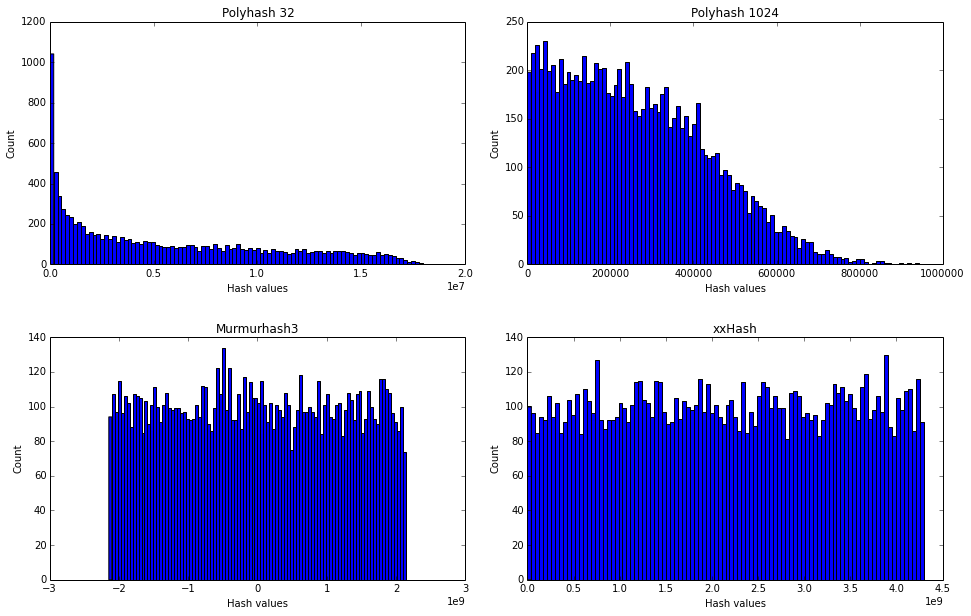

In [87]:
load("images/hashes_5_0.png")

Above plots describe hashing done on 10000 different input data with _same seed_. _Polynomial hash functions_ exhibit high collision compared to _Murmur_ and _xxHash_. Distribution of _Murmurhash_ and _xxHash_ is uniform.

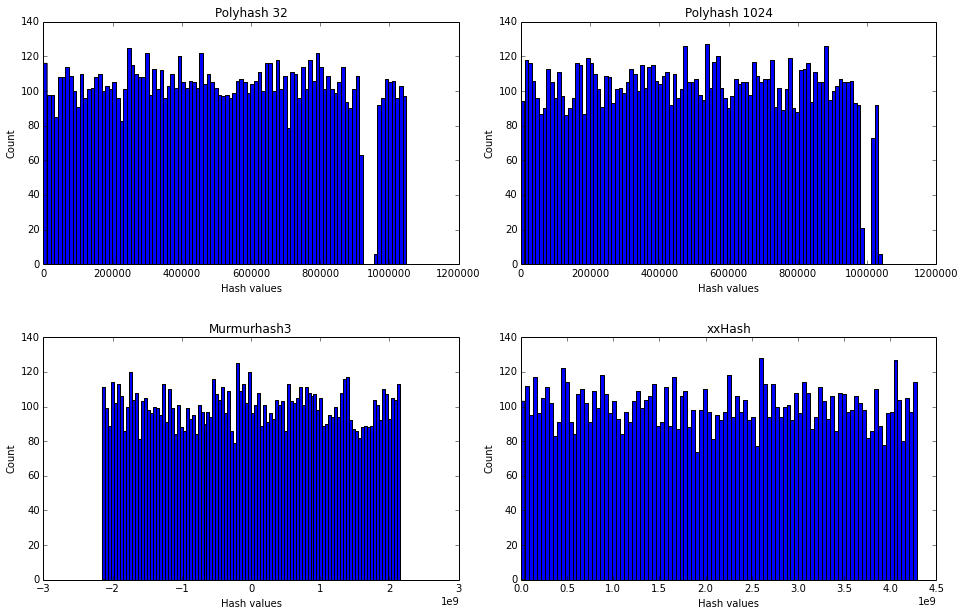

In [88]:
load("images/hashes_7_0.png")

Hashing of same data (size 1024 characters) with 10000 different seeds. All the hash functions exibit relatively less collisions.

#### Time Complexity

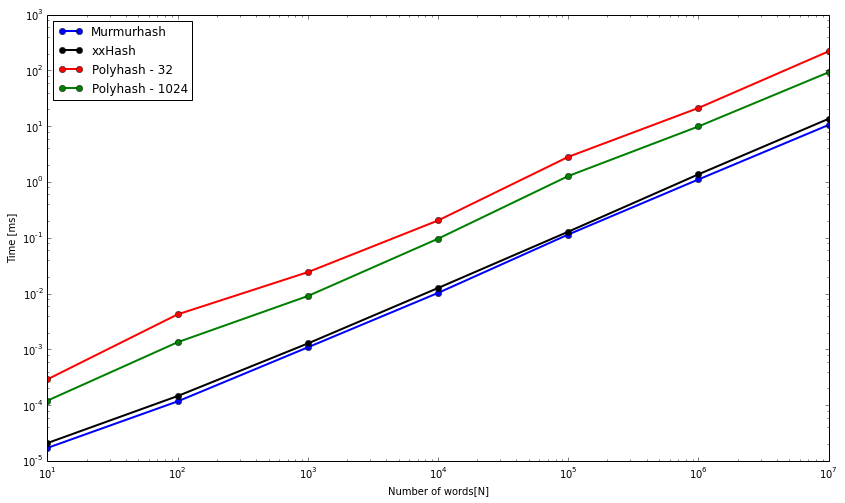

In [89]:
load("images/hashes_10_0.png")

The performance of a hash function with regards to time is the time taken to produce a hash value. The performance of Murmurhash and xxHash functions does not show a big difference, although Murmurhash performs slightly better. It is surprising that the polyhash is taking more time than Murmurhash and xxHash which have signficantly less collision. With more careful implementation the polyhash runtime can be reduced. In this setting we are using our own implementation of polyhash while using the default library implementation of Murmur and xxHash function, whose implementations are carefully engineered.

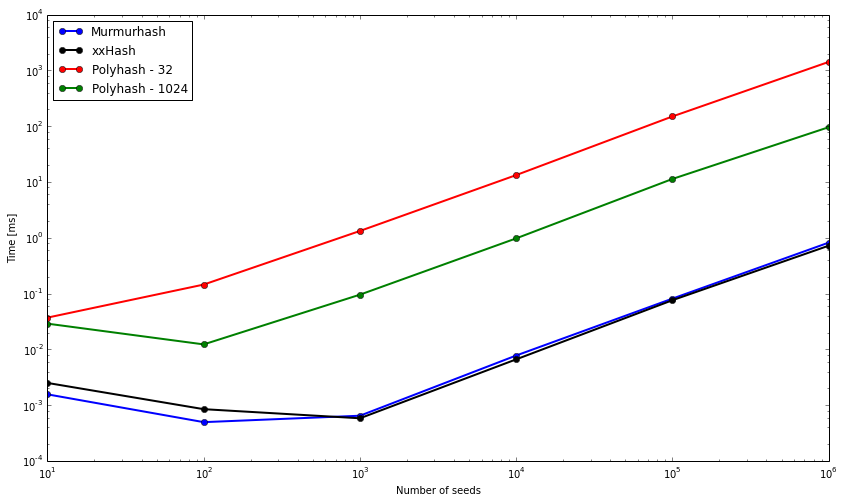

In [90]:
load("images/hashes_12_0.png")

The plots show the performance of hash functions with same data and different seeds. The data used is words of size 1024 characters and seeds are randomly generated. In this case xxHash slightly outperforms Murmurhash with large input size (word length 1024).

## Flajolet-Martin Algorithm for Approximating $F_0$ 

### The Algorithm

The Flajolet Martin algorithm [4] is used to calculate the cardinality of the multiset, i.e. the zero'th frequency moment. Time complexity is denoted in the order of input data size $O(n)$ and space compexity in the order of $O(h)$, where $h$ is the count of hash functions.

The Algorithm can be described as follows:

- Initialize a bit-vector $BITMAP$ to be of length $L$ and contain all 0's.
- For each element $x$ in $M$:
    - $index = \rho(\text{hash}(x))$.
    - $BITMAP[index] = 1$.
- Let $R$ denote the smallest index $i$ such that $BITMAP[i] = 0$.
- Estimate the cardinality of $M$ as $2^R / \phi$ where $\phi \approx 0.77351$ (see [4] for details)

In the experiments we used an improved estimation procedure as described in [5] by taking $k$ hashes of each each element to achieve $k$ approximations $M_i$. We then grouped these approximations into a different number of groups $-$ the number of groups is specified by the _group size ratio_ $-$, computed the median of each group and afterwards the average of these medians.

The following function implements the algorithm in Julia, using MurmurHash:

In [91]:
function fmaF0(file, num_hashes::Int, group_size_ratio::Float64)

    Φ = 0.77351

    seeds = rand(1:num_hashes, num_hashes)
    max_tail_lengths = zeros(num_hashes)

    open(file) do filehandle
        for line in eachline(filehandle)
            for k in 1:length(seeds)
                tail_length = trailing_zeros(Murmur3.x86.hash32(line, seeds[k]))
                max_tail_lengths[k] = max(max_tail_lengths[k], tail_length)
            end
        end
    end

    max_tail_lengths = Φ * 2.^max_tail_lengths

    # take medians of groups and then the mean over them
    group_size = round(Int, num_hashes * group_size_ratio, RoundDown)
    num_groups = round(Int, num_hashes / group_size, RoundUp)

    medians = zeros(num_groups)
    for i in 1:num_groups
        group_start = (i-1)*group_size + 1
        group_end = i*group_size

        # the last group is smaller:
        if i == num_groups
            group_end = num_hashes
        end

        medians[i] = median(max_tail_lengths[group_start:group_end])
    end
    return mean(medians)
end;

### Results

The following results were computed using the FMA algorithm using the different hash functions:

    Exact computation: 843
    F0 Approximation Polyhash32:  595
    F0 Approximation Polyhash1024:  595
    F0 Approximation Murmurhash:  959
    F0 Approximation xxHash:  711

#### Quality of Hash functions

Performance of hash function depends on the randomness and collision ratio of the hash functions. It is generally observed that more costly hash functions to exhibit less collision ratio and better randomness. Hence the performance of costly hash functions will be usually better. But in our case polyhash is costly and giving hash with high collision ratio. So our expectation was that the approximation of _xxHash_ and _Murmurhash_ has to be better than _polynomial hash functions_, which is also the case here. The approximation using _Murmur_ and _xxHash_ is better.

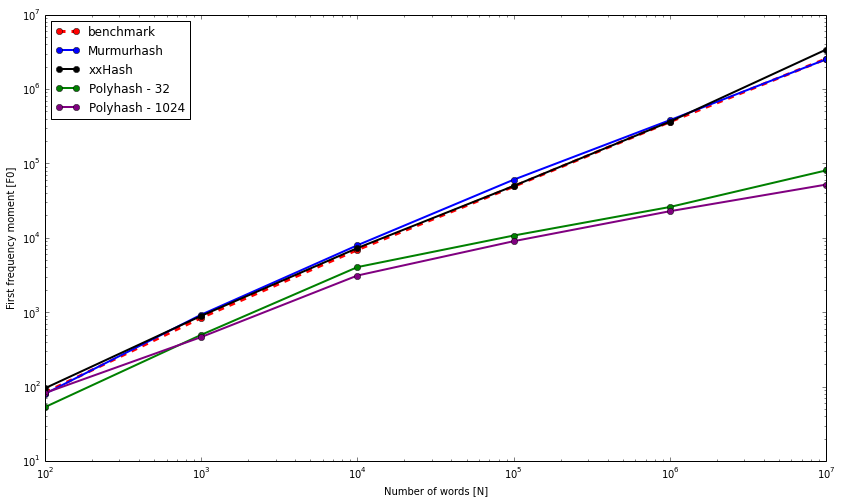

In [92]:
load("images/hashes_17_0.png")

The above plot shows the approximation of $F_0$ using different hash functions. Our test results are based on 100 different hash functions for each family and grouping factor of 0.1 to choose the median (mean of medians is used to get better approximation results).

#### Count of Hash functions

From the plots above we infer that quality (collision ratio) of hash functions helps in getting better approximation results. Increasing the hash functions count improves approximation results intially for small value of hash function count but having too many hash functions doesnot improve the approximation results.

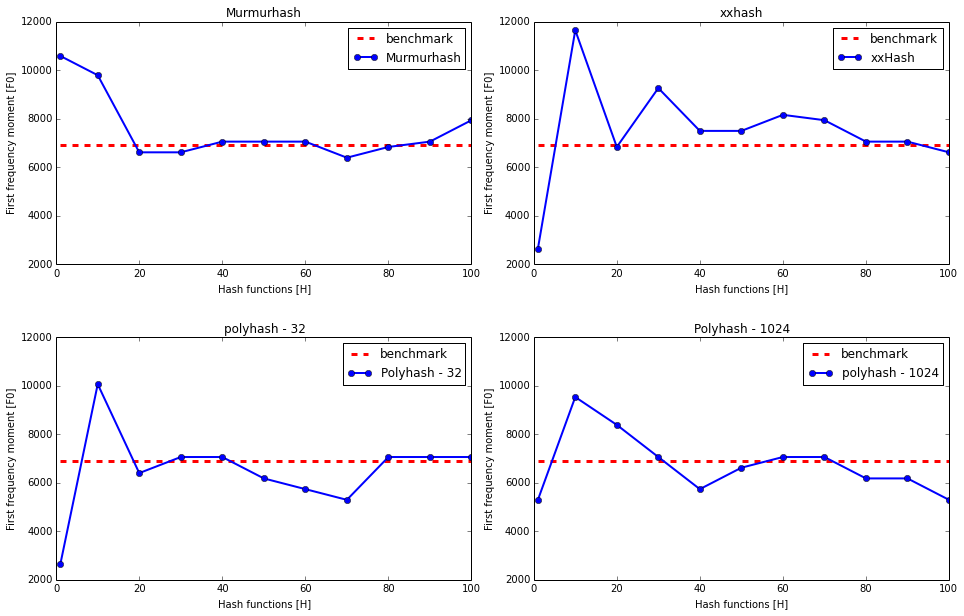

In [93]:
load("images/hashes_20_0.png")

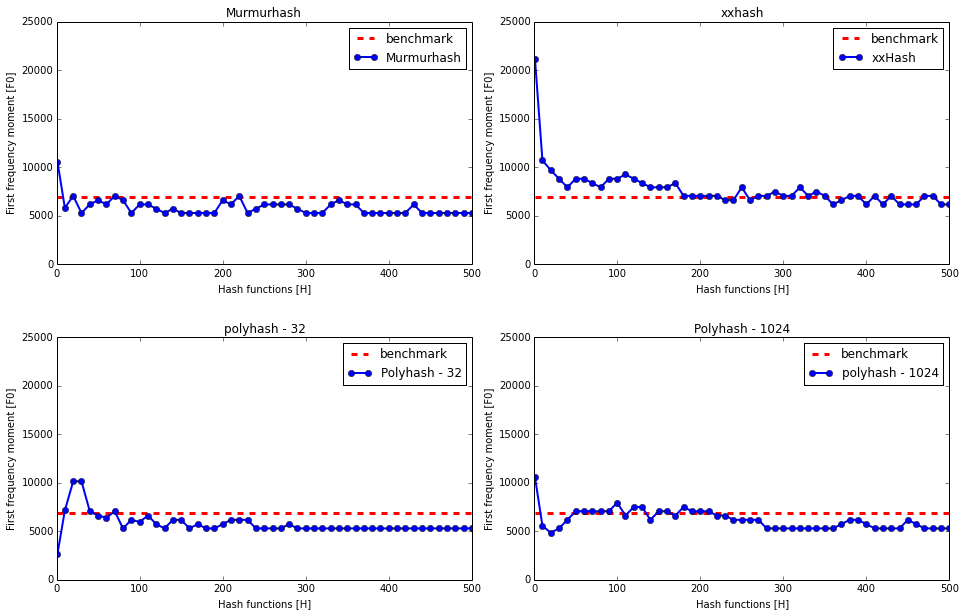

In [94]:
load("images/hashes_21_0.png")

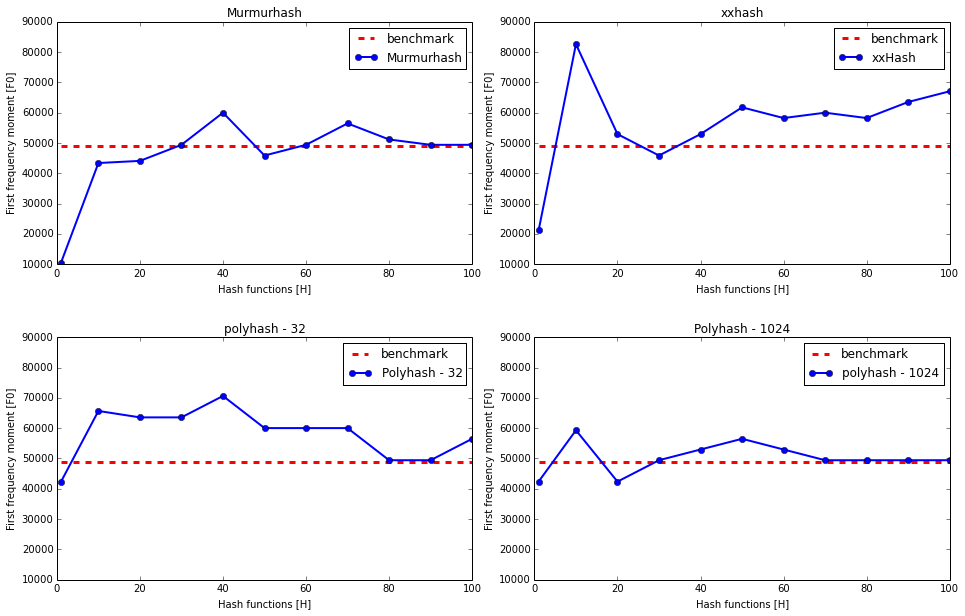

In [95]:
load("images/hashes_22_0.png")

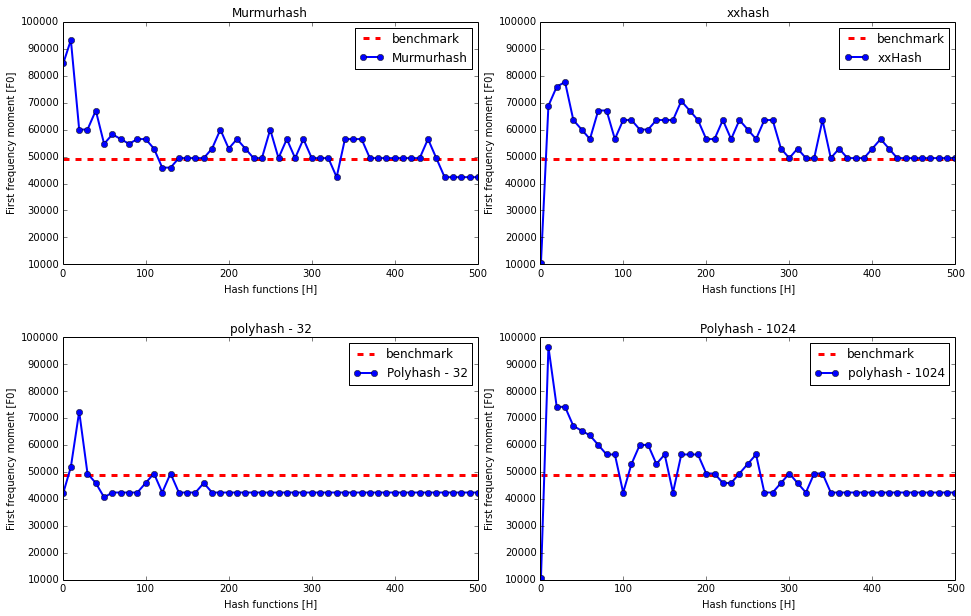

In [96]:
load("images/hashes_23_0.png")

## Alon-Matias-Szegedy Algorithm for Approximating $F_2$

Let $A = {a_1,a_2,...a_m}$ be the sequence of elments, where $a_i$ is the member of $N={1,2,...n}$. Then $$F_2=\sum\limits_{i=1}^{n}{m_i}^2$$ is the _repeat rate_ or _Gini's index of homogenity_. Alon Matias Szegedy Algorithm is used to approximate the frequency moment $F_k$. The estimator works as follows. Pick a token from the stream uniformly at random, i.e., pick a position $J{\in}_R[m]$ . Count the length, $m$, of the stream and the number, $r$, of occurrences of our picked token $a_j$ in the stream from that point on: $r=\mid\{j\geq J:a_j=a_J\}\mid$. The basic estimator is then defined to be $m(r^k-{(r-1)}^k)$.

### Median of means Improvement
we cannot apply the median trick to our basic estimator directly. This is because its variance is so large that we are unable to bound below $1/2$ the probability of an relative deviation in the estimator. So we first bring the variance down by averaging a number of independent copies of the basic estimator, and then apply the median trick.

The Algorithm computes $s_2$ number of random variables $Y_1,Y_2,...,Y_{s_2}$ and outputs thier median $Y$. Each $Y_i$ is the average of $s_1$ random variables $X_{ij}:1\leq j\leq s_1$, where the $X_ij$ are independent, identically distributed random variables. Each of the variables $X=X_ij$ is computed from the sequence in the same way, using $O(log n +log m)$ memory bits, as follows. Choose a random member $a_p$ of the sequence $A_i$, where the index $p$ is chosen randomly and uniformly among the numbers $1,2,...,m$. Suppose that $a_p=l ( \in N=\{1,2,...,n\})$. Let $$ r=\mid\{q: q\geq p:a_q=l\}\mid (\geq 1)$$ be the number of occurances of $l$ among the members of the sequence A following $a_p$ (inclusive), and $$X=m(r^k-{(r-1)}^k).$$

In [97]:
function amsF2(file, stream_size::Int, num_variables::Int)

    # choose positions of variables in stream uniformly at random
    positions = sample(1:stream_size, num_variables, replace=false)

    # Dict that stores our variables and their values
    dict = Dict()

    open(file) do filehandle
        for (index, value) in enumerate(eachline(filehandle))

            # if the current stream element isn't in our Dict
            if get(dict, value, 0) == 0
                # check if we reached a position in the stream to
                # initialize our next variable
                if in(index, positions)
                    # store the element in our Dict
                    dict[value] = 1
                end
            else
                # the element is in our Dict, increase its count
                dict[value] += 1
            end
        end
    end
        
    estimates = (2 .* collect(values(dict)) .- 1) * stream_size
    
    return mean(estimates)
    
end;

### Approximating $F_2$

Approximation results for toy data of 10000 words.

Plot shows the approximation of $F_2$ using Alon Matias Szegedy Algorithm with $m=100$ and $10^3 \leq n \leq 10^7$. Approximation is giving better results with median of mean improvement.

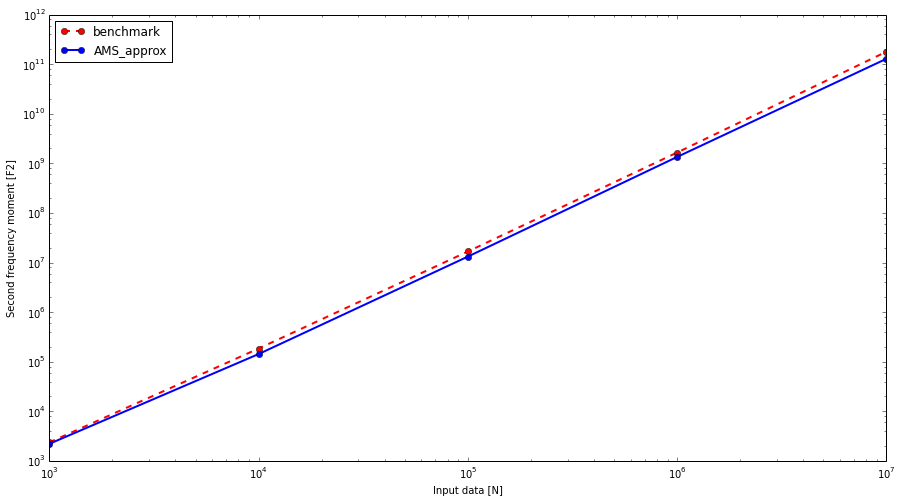

In [6]:
load("images/ams_30_0.png")

### Count of Variables _(m)_
Increasing the variable count improves approximation results intially, but having too many hash functions doesnot improve the approximation results. Insted the approximation results are getting worse (This is strange behaviour).

Plot shows the approximation of $F_2$ using Alon Matias Szegedy Algorithm with $m=100$ and $10^3 \leq n \leq 10^7$. Approximation is giving better results with median of mean improvement.

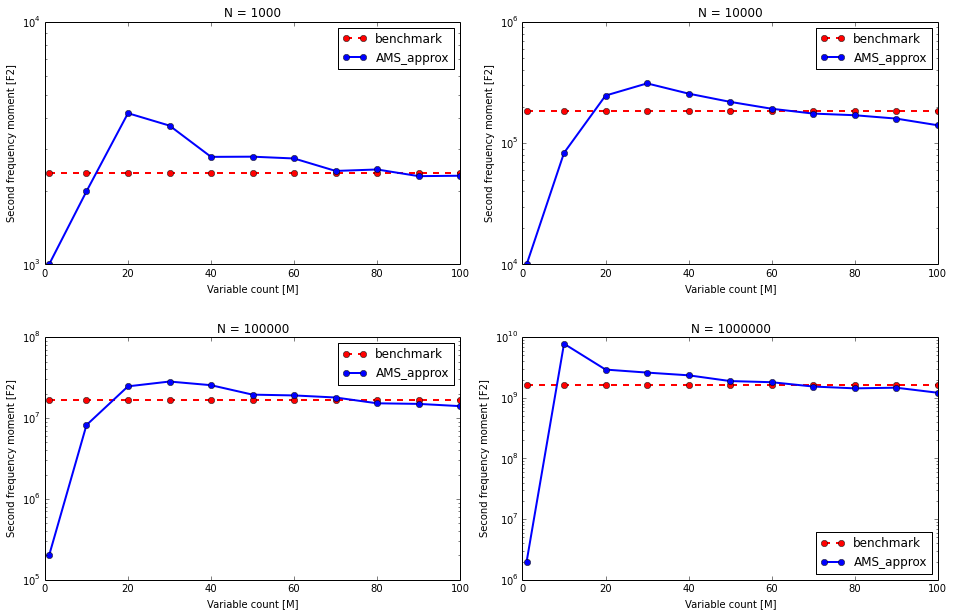

In [7]:
load("images/ams_31_0.png")

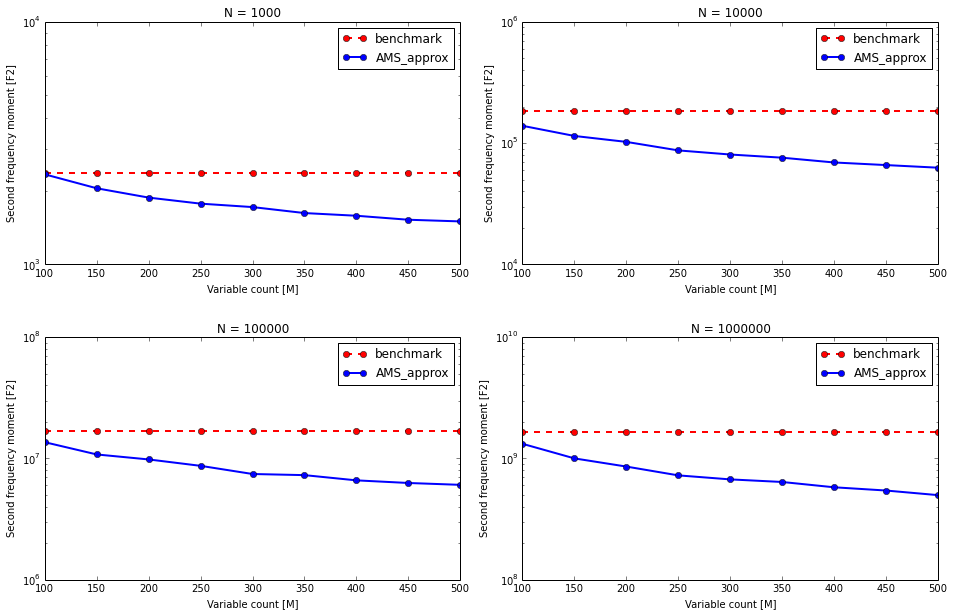

In [8]:
load("images/ams_32_0.png")

# Results

Results for complete run of twitter_words.txt

- Exact count single pass 
    - $F_0$: 100691877 $F_2$: 1636226219110186 
    - Total word count: 894092304 

- Approximation results
    - approximation F_0 Murmurhash: 100397414
    - approximation F_0 xxHash: 100487516

- Approximation results F_2
    - AMS approximation F_2: 1597845951647948

# References

[1] Jeff Bezanson, et al. "The Julia Language". Julialang.org. N.p., 2015. Web. 30 Dec. 2015. http://julialang.org

[2] Jupyter.org,. "Project Jupyter". N.p., 2015. Web. 30 Dec. 2015. http://jupyter.org

[3] Alon, Noga, Yossi Matias, and Mario Szegedy. "The space complexity of approximating the frequency moments." Proceedings of the twenty-eighth annual ACM symposium on Theory of computing. ACM, 1996.

[4] P. Flajolet and G. N. Martin. Probabilistic counting algorithms for data base applications. Journal of computer and system sciences, 31(2):182–209, 1985.

[5] J. Leskovec, A. Rajaraman, and J. Ullman. Mining of massive datasets. Cambridge University Press, 2014.

[6] I. J. Good, Surprise indexes and P-values, J. Statistical Computation and Simulation 32 (1989), 90-92.

[7] Hpl.hp.com,. N.p., 2015. Web. 30 Dec. 2015. http://www.hpl.hp.com/techreports/98/HPL-98-135.pdf?jumpid=reg_R1002_USEN 

[8] Wikipedia,. "Murmurhash". N.p., 2015. Web. 30 Dec. 2015. https://en.wikipedia.org/wiki/MurmurHash

[9] Programmers.stackexchange.com,. "Which Hashing Algorithm Is Best For Uniqueness And Speed?". N.p., 2015. Web. 30 Dec. 2015. http://programmers.stackexchange.com/questions/49550/which-hashing-algorithm-is-best-for-uniqueness-and-speed

[10] Code.google.com,. "Xxhash - Extremely Fast Non-Cryptographic Hash Algorithm - Google Project Hosting". N.p., 2015. Web. 30 Dec. 2015. https://code.google.com/p/xxhash/

# Appendix